In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets

# Update Ward Function

In [4]:
def ward(ward_ac, ward_bc, ward_ab, len_a, len_b, len_c):
    return (((len_a + len_c) * ward_ac) + ((len_b + len_c) * ward_bc) - (len_c * ward_ab)) / (len_a + len_b + len_c)

#  Cut at level 147

In [5]:
iris = datasets.load_iris()
iris_data = iris.data
data = iris_data
cutoff = 147

# The matrix of the number of points in each cluster to be calculated (Ward) in the updates

In [73]:
points_in_cluster = np.ones((data.shape[0],data.shape[0],2))
points_in_cluster.shape

(150, 150, 2)

# Calculate primary ward matrix

In [74]:
wards_matrix = np.zeros((data.shape[0],data.shape[0]))
for i in range(0,data.shape[0]):
    for j in range(0,data.shape[0]):
        if j <= i:
            dist = np.linalg.norm(data[i] - data[j])
            wards_matrix[i,j] = dist**2 / 2
wards_matrix[wards_matrix == 0] = np.inf 

wards_matrix

array([[   inf,    inf,    inf, ...,    inf,    inf,    inf],
       [ 0.145,    inf,    inf, ...,    inf,    inf,    inf],
       [ 0.13 ,  0.045,    inf, ...,    inf,    inf,    inf],
       ...,
       [ 9.945, 10.12 , 10.865, ...,    inf,    inf,    inf],
       [10.815, 11.13 , 11.755, ...,  0.19 ,    inf,    inf],
       [ 8.57 ,  8.625,  9.24 , ...,  0.205,  0.295,    inf]])

In [75]:
df = pd.DataFrame(data=np.ones(data.shape[0])*np.inf)

# main part of algorithm in O(n^3) 

In [76]:
if cutoff > wards_matrix.shape[0]:
    cutoff = wards_matrix.shape[0]
d = {}
index = 1
for i in range(0,cutoff):
    ij_min = np.unravel_index(wards_matrix.argmin(), wards_matrix.shape) 
    
    if i == 0:
        df.iloc[ij_min[0]] = 0
        df.iloc[ij_min[1]] = 0
    else:
        try:
            a = int(df.iloc[ij_min[0]])
        except:
            df.iloc[ij_min[0]] = i
            a = i
        try:
            b = int(df.iloc[ij_min[1]])
        except:
            df.iloc[ij_min[1]] = i
            b = i
        df[(df[0]==a) | (df[0]==b)] = i

    d[i] = ij_min
    
    for j in range(0, wards_matrix.shape[1]):
        ij_min_0 = np.isfinite(wards_matrix[ij_min[0]][j])
        ij_min_1 = np.isfinite(wards_matrix[ij_min[1]][j])
        
        if ij_min_0 and ij_min_1:
            ward_ab = wards_matrix[ij_min]
            ward_ac = wards_matrix[ij_min[0]][j]
            ward_bc = wards_matrix[ij_min[1]][j]
            len_a = points_in_cluster[ij_min][0]
            len_b = points_in_cluster[ij_min][1]
            len_c = points_in_cluster[ij_min[0],j][1]
            
            wards_matrix[ij_min[1]][j] = ward(ward_ac, ward_bc, ward_ab, len_a, len_b, len_c)

            points_in_cluster[ij_min[1]][j][0] = len_a + len_b
            points_in_cluster[ij_min[1]][j][1] = len_c

        elif (j==0):
            continue
        else:
            if not ((j == ij_min[0]) or (j == ij_min[1])):
                if np.isfinite(wards_matrix[j][ij_min[1]]):
                    if(ij_min_0 and not ij_min_1):  
                        ward_ab = wards_matrix[ij_min]
                        ward_ac = wards_matrix[ij_min[0]][j]
                        ward_bc = wards_matrix[j][ij_min[1]]
                        len_a = points_in_cluster[ij_min][0]
                        len_b = points_in_cluster[ij_min][1]
                        len_c = points_in_cluster[j,ij_min[0]][1]

                        wards_matrix[j][ij_min[1]] = ward(ward_ac, ward_bc, ward_ab, len_a, len_b, len_c)

                        points_in_cluster[j][ij_min[1]][0] = len_a + len_b
                        points_in_cluster[j][ij_min[1]][1] = len_c
                        
                    if(ij_min_1 and not ij_min_0):        
                        ward_ab = wards_matrix[ij_min]
                        ward_ac = wards_matrix[j][ij_min[0]]
                        ward_bc = wards_matrix[ij_min[1]][j]
                        len_a = points_in_cluster[ij_min][0]
                        len_b = points_in_cluster[ij_min][1]
                        len_c = points_in_cluster[j,ij_min[0]][1]

                        wards_matrix[ij_min[1]][j] = ward(ward_ac, ward_bc, ward_ab, len_a, len_b, len_c)

                        points_in_cluster[ij_min[1]][j][0] = len_a + len_b
                        points_in_cluster[ij_min[1]][j][1] = len_c

                    if(not ij_min_1 and not ij_min_0):                                       
                        ward_ab = wards_matrix[ij_min]
                        ward_ac = wards_matrix[j][ij_min[0]]
                        ward_bc = wards_matrix[j][ij_min[1]]
                        len_a = points_in_cluster[ij_min][0]
                        len_b = points_in_cluster[ij_min][1]
                        len_c = points_in_cluster[j,ij_min[0]][0]

                        wards_matrix[j][ij_min[1]] = ward(ward_ac, ward_bc, ward_ab, len_a, len_b, len_c)

                        points_in_cluster[j][ij_min[1]][0] = len_a + len_b
                        points_in_cluster[j][ij_min[1]][1] = len_c

    wards_matrix[ij_min[0]][:] = np.inf
    wards_matrix[:,ij_min[0]] = np.inf
    
    points_in_cluster[ij_min[0]][:] = np.inf
    points_in_cluster[:,ij_min[0]] = np.inf

#     if index >= 3:
#         break
#     index = index + 1
    

target = df[0].to_numpy();

In [77]:
target

array([143., 143., 143., 143., 143., 143., 143., 143., 143., 143., 143.,
       143., 143., 143., 143., 143., 143., 143., 143., 143., 143., 143.,
       143., 143., 143., 143., 143., 143., 143., 143., 143., 143., 143.,
       143., 143., 143., 143., 143., 143., 143., 143., 143., 143., 143.,
       143., 143., 143., 143., 143., 143., 145., 145., 145., 145., 145.,
       145., 145., 145., 145., 145., 145., 145., 145., 145., 145., 145.,
       145., 145., 146., 145., 146., 145., 146., 145., 145., 145., 145.,
       145., 145., 145., 145., 145., 145., 146., 145., 145., 145., 146.,
       145., 145., 145., 145., 145., 145., 145., 145., 145., 145., 145.,
       145., 146., 146., 146., 146., 146., 146., 145., 146., 146., 146.,
       146., 146., 146., 146., 146., 146., 146., 146., 146., 146., 146.,
       146., 146., 146., 146., 146., 146., 146., 146., 146., 146., 146.,
       146., 146., 146., 146., 146., 146., 146., 146., 146., 146., 146.,
       146., 146., 146., 146., 146., 146., 146.])

In [78]:
target[target == 143] = 0
target[target == 145] = 1
target[target == 146] = 2

target

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       2., 1., 2., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1.,
       1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2.,
       2., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

In [79]:
iris.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

# Comparison of data based on feature one and two

Text(0.5, 0, 'my clustering label (ward method)')

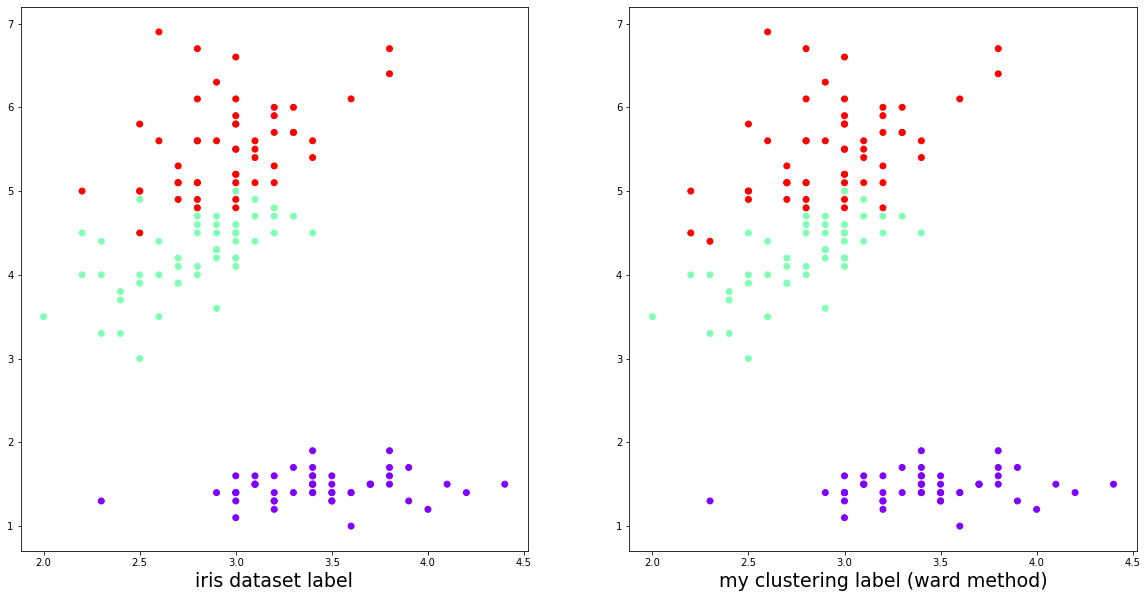

In [80]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(iris_data[:,1], iris_data[:,2], c=iris.target, cmap="rainbow")
plt.xlabel("iris dataset label", fontsize=19)

plt.subplot(1,2,2)
plt.scatter(iris_data[:,1], iris_data[:,2], c=target, cmap="rainbow")
plt.xlabel("my clustering label (ward method)", fontsize=19)

# Comparison of data based on feature two and three

Text(0.5, 0, 'my clustering label (ward method)')

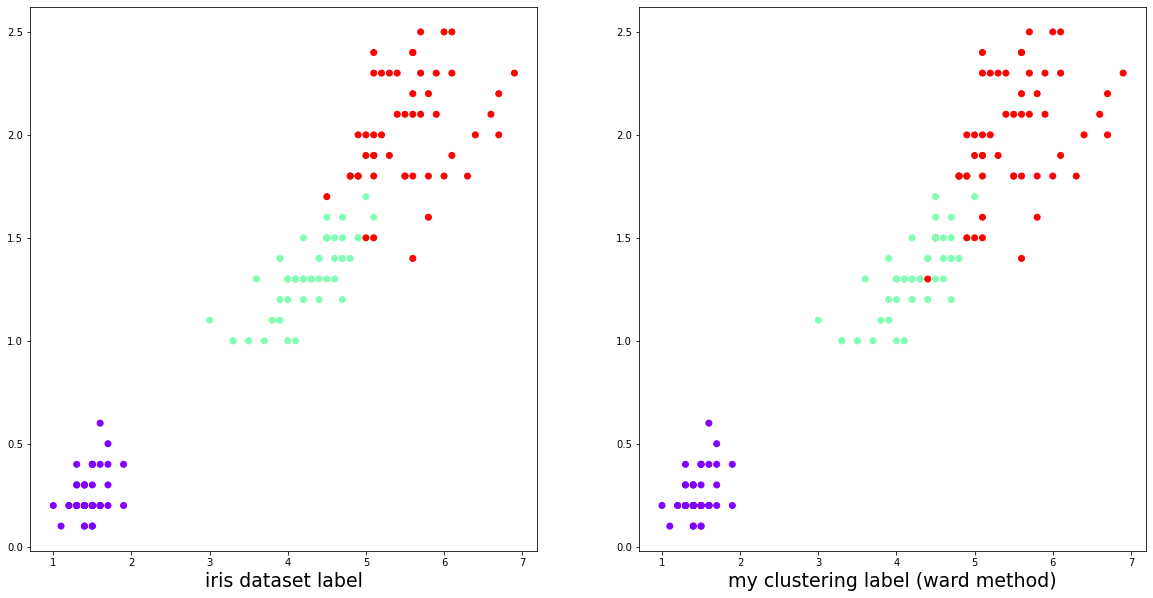

In [81]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(iris_data[:,2], iris_data[:,3], c=iris.target, cmap="rainbow")
plt.xlabel("iris dataset label", fontsize=19)

plt.subplot(1,2,2)
plt.scatter(iris_data[:,2], iris_data[:,3], c=target, cmap="rainbow")
plt.xlabel("my clustering label (ward method)", fontsize=19)

#  Comparison of data based on feature one and three

Text(0.5, 0, 'my clustering label (ward method)')

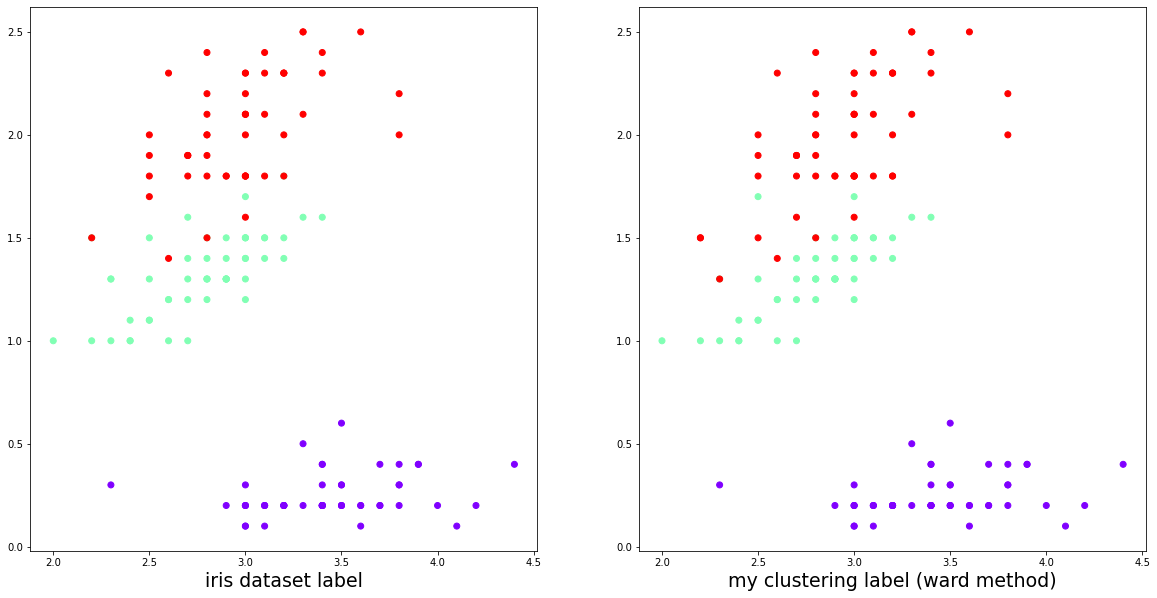

In [82]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(iris_data[:,1], iris_data[:,3], c=iris.target, cmap="rainbow")
plt.xlabel("iris dataset label", fontsize=19)

plt.subplot(1,2,2)
plt.scatter(iris_data[:,1], iris_data[:,3], c=target, cmap="rainbow")
plt.xlabel("my clustering label (ward method)", fontsize=19)